# Notebook 1 : Préparation et nettoyage des données immobilières

---

## 📑 Table des matières

1. [Introduction](#Introduction)
2. [Import des bibliothèques](#Import-des-bibliothèques)
3. [Chargement des données brutes](#Chargement-des-données-brutes)
4. [Exploration initiale des données](#Exploration-initiale-des-données)
5. [Nettoyage des données](#Nettoyage-des-données)
6. [Transformation et enrichissement](#Transformation-et-enrichissement)
7. [Analyses statistiques descriptives](#Analyses-statistiques-descriptives)
8. [Visualisations exploratoires](#Visualisations-exploratoires)
9. [Export des données nettoyées](#Export-des-données-nettoyées)
10. [Synthèse du nettoyage](#Synthèse-du-nettoyage)

---

## Introduction

### Objectif de ce notebook
- Nettoyage des données DVF2024 

### Sources de données utilisées

DVF2024 : 

---

## Import des bibliothèques


In [1]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Utilitaires
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# CODEZ ICI: Imports supplémentaires si nécessaire

---

## Chargement des données brutes

### Chargement du fichier DVF principal

In [2]:
# CODEZ ICI: Charger le(s) fichier(s) DVF
# --- Fonctions utilitaires de base ---

def load_data(path, sep=','):
    """
    Charge un CSV et renvoie un DataFrame.
    Par défaut : séparateur = ',' (à adapter si ton CSV DVF utilise ';')
    """
    df = pd.read_csv(path, sep=sep, low_memory=False)
    return df

In [3]:
def initial_exploration(df, dataset_name="Dataset"):
    """
    Affiche un aperçu rapide de la structure du dataset :
    dimensions, colonnes et types de données.
    """
    print(f"\nStructure du dataset : {dataset_name}")
    print(f"Nombre de lignes : {df.shape[0]}")
    print(f"Nombre de colonnes : {df.shape[1]}\n")

    print("Noms des colonnes :")
    print(df.columns.tolist())
    print("\nTypes de données :")
    print(df.dtypes)

In [4]:
df_raw = load_data("data/full.csv", sep=',')  
initial_exploration(df_raw, "DVF 2024 brut")


Structure du dataset : DVF 2024 brut
Nombre de lignes : 3458643
Nombre de colonnes : 40

Noms des colonnes :
['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', 'valeur_fonciere', 'adresse_numero', 'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune', 'nom_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude']

Types de données :
id_mutation                      object
date_mutation                    object
numero_disposition  

---

## Exploration initiale des données

### Filtrer sur les données de IDF


In [5]:
def filter_ile_de_france(df):
    """
    Filtre les données DVF pour ne garder que les départements d'Île-de-France.
    """
    idf_codes = ["75", "77", "78", "91", "92", "93", "94", "95"]

    # On convertit le code_departement en string pour éviter les erreurs de comparaison
    df["code_departement"] = df["code_departement"].astype(str)

    # Filtrage
    df_idf = df[df["code_departement"].isin(idf_codes)].copy()

    print("Filtrage Île-de-France effectué avec succès ")
    print(f"Nombre de lignes avant filtrage : {len(df)}")
    print(f"Nombre de lignes après filtrage (IDF) : {len(df_idf)}")
    print(f"Départements présents : {sorted(df_idf['code_departement'].unique())}")

    return df_idf

# Application du filtre
df_idf = filter_ile_de_france(df_raw)

Filtrage Île-de-France effectué avec succès 
Nombre de lignes avant filtrage : 3458643
Nombre de lignes après filtrage (IDF) : 414144
Départements présents : ['75', '77', '78', '91', '92', '93', '94', '95']


In [6]:
"""Comptage par departement """
df_idf["code_departement"].value_counts().sort_index()

code_departement
75    74279
77    62339
78    46171
91    41114
92    57795
93    50573
94    43949
95    37924
Name: count, dtype: int64

### Analyse des colonnes

<!-- COMPLÉTEZ ICI: Décrivez les colonnes principales du dataset DVF -->
<!-- Exemple: -->
<!-- - date_mutation: date de la transaction -->
<!-- - valeur_fonciere: prix de vente -->
<!-- - type_local: appartement, maison, etc. -->
<!-- - surface_reelle_bati: surface en m² -->
<!-- - nombre_pieces_principales: nombre de pièces -->
<!-- - code_postal, commune -->

In [7]:
def analyze_columns(df, dataset_name="Dataset", topn=10):
    print(f"\n=== Analyse des colonnes : {dataset_name} ===")

    # Résumé compact
    summary = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "na_cnt": df.isna().sum(),
        "na_pct": (df.isna().mean()*100).round(2),
        "nunique": df.nunique(dropna=True)
    }).sort_index()

    display(summary.sort_values(["na_pct","nunique"], ascending=[False, True]))

    # Zoom par colonne (catégorielle vs numérique)
    for col in df.columns:
        s = df[col]
        print(f"\n--- {col} ---")
        print(f"dtype={s.dtype}, na_pct={s.isna().mean():.2%}, nunique={s.nunique(dropna=True)}")

        if pd.api.types.is_numeric_dtype(s):
            desc = s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
            display(desc.to_frame(name=col))
        else:
            vc = (s.value_counts(dropna=True)
                    .head(topn)
                    .to_frame(name="freq"))
            display(vc)

# Lance l'analyse sur le sous-ensemble IDF
analyze_columns(df_idf, "DVF IDF brut", topn=10)



=== Analyse des colonnes : DVF IDF brut ===


dtype  na_cnt  na_pct  nunique
ancien_code_commune           float64  414144  100.00        0
ancien_id_parcelle             object  414144  100.00        0
ancien_nom_commune             object  414144  100.00        0
lot5_surface_carrez           float64  413973   99.96      103
lot4_surface_carrez           float64  413646   99.88      263
numero_volume                  object  412736   99.66      226
lot5_numero                   float64  412437   99.59      270
lot3_surface_carrez           float64  411848   99.45     1064
lot4_numero                    object  410028   99.01      383
lot3_numero                    object  401965   97.06      684
code_nature_culture_speciale   object  400737   96.76       36
nature_culture_speciale        object  400737   96.76       36
adresse_suffixe                object  390575   94.31       28
lot2_surface_carrez           float64  387546   93.58     7338
lot1_surface_carrez           float64  326736   78.89    12690
lot2_numero                    object  323233   78.05     2654
code_nature_culture            object  267554   64.60       20
nature_culture                 object  267554   64.60       20
surface_terrain               float64  267557   64.60     7166
surface_reelle_bati           float64  249457   60.23     1609
lot1_numero                    object  149341   36.06     6240
nombre_pieces_principales     float64   85402   20.62       24
code_type_local               float64   85209   20.57        4
type_local                     object   85209   20.57        4
adresse_numero                float64   54978   13.28     1106
code_postal                   float64    7728    1.87      526
adresse_code_voie              object    7728    1.87     6240
adresse_nom_voie               object    7728    1.87    32824
latitude                      float64    3122    0.75   111107
longitude                     float64    3122    0.75   117867
valeur_fonciere               float64    2486    0.60    29997
nature_mutation                object       0    0.00        6
code_departement               object       0    0.00        8
nombre_lots                     int64       0    0.00       57
numero_disposition              int64       0    0.00       85
date_mutation                  object       0    0.00      320
nom_commune                    object       0    0.00     1269
code_commune                   object       0    0.00     1273
id_parcelle                    object       0    0.00   127978
id_mutation                    object       0    0.00   159388


--- id_mutation ---
dtype=object, na_pct=0.00%, nunique=159388


freq
id_mutation       
2024-1134925  4089
2024-1123211  1878
2024-1147640  1594
2024-1099383   882
2024-1156897   846
2024-924466    819
2024-1109754   785
2024-1208245   769
2024-1123212   643
2024-929966    631


--- date_mutation ---
dtype=object, na_pct=0.00%, nunique=320


freq
date_mutation      
2024-03-07     9452
2024-12-20     7796
2024-11-25     5355
2024-12-19     5339
2024-12-30     5012
2024-06-27     4236
2024-09-30     3987
2024-06-28     3867
2024-12-23     3694
2024-12-27     3523


--- numero_disposition ---
dtype=int64, na_pct=0.00%, nunique=85


numero_disposition
count       414144.000000
mean             1.315320
std              2.423014
min              1.000000
1%               1.000000
5%               1.000000
25%              1.000000
50%              1.000000
75%              1.000000
95%              1.000000
99%             11.000000
max             85.000000


--- nature_mutation ---
dtype=object, na_pct=0.00%, nunique=6


freq
nature_mutation                           
Vente                               363090
Vente en l'état futur d'achèvement   46989
Echange                               2138
Adjudication                           924
Expropriation                          596
Vente terrain à bâtir                  407


--- valeur_fonciere ---
dtype=float64, na_pct=0.60%, nunique=29997


valeur_fonciere
count     4.116580e+05
mean      3.323174e+06
std       1.263204e+07
min       1.500000e-01
1%        6.000000e+02
5%        1.850000e+04
25%       1.780000e+05
50%       3.100000e+05
75%       7.000000e+05
95%       1.550000e+07
99%       1.030380e+08
max       2.550000e+08


--- adresse_numero ---
dtype=float64, na_pct=13.28%, nunique=1106


adresse_numero
count   359166.000000
mean       268.475816
std       1385.456654
min          1.000000
1%           1.000000
5%           1.000000
25%          7.000000
50%         20.000000
75%         53.000000
95%        193.000000
99%       9001.000000
max       9999.000000


--- adresse_suffixe ---
dtype=object, na_pct=94.31%, nunique=28


freq
adresse_suffixe       
B                18107
T                 2383
A                 1298
P                  523
C                  400
D                  290
Q                  216
E                   84
F                   68
Z                   30


--- adresse_nom_voie ---
dtype=object, na_pct=1.87%, nunique=32824


freq
adresse_nom_voie              
AV DE LA REPUBLIQUE       2360
RUE DE PARIS              2144
RUE DE LA BARRE NOUVELLE  1877
AV JEAN JAURES            1739
AV LEON BLUM              1678
RUE GABRIEL FAURE         1648
AV DU GENERAL DE GAULLE   1506
GR GRANDE RUE             1303
RUE PASTEUR               1187
RUE JEAN JAURES           1155


--- adresse_code_voie ---
dtype=object, na_pct=1.87%, nunique=6240


freq
adresse_code_voie      
0640               2837
0020               2494
0080               1957
0060               1946
0140               1837
0040               1817
0125               1802
5132               1601
0100               1532
0220               1399


--- code_postal ---
dtype=float64, na_pct=1.87%, nunique=526


code_postal
count  406416.000000
mean    85829.482442
std      8346.481024
min     75001.000000
1%      75004.000000
5%      75011.000000
25%     77300.000000
50%     91340.000000
75%     93200.000000
95%     95310.000000
99%     95690.000000
max     95880.000000


--- code_commune ---
dtype=object, na_pct=0.00%, nunique=1273


freq
code_commune      
93006         8923
75115         8305
75116         7150
75111         6174
75117         6022
75118         5766
93010         5524
75120         4762
75112         4531
92012         4152


--- nom_commune ---
dtype=object, na_pct=0.00%, nunique=1269


freq
nom_commune                   
Bagnolet                  8923
Paris 15e Arrondissement  8305
Paris 16e Arrondissement  7150
Paris 11e Arrondissement  6174
Paris 17e Arrondissement  6022
Paris 18e Arrondissement  5766
Bondy                     5524
Paris 20e Arrondissement  4762
Paris 12e Arrondissement  4531
Boulogne-Billancourt      4152


--- code_departement ---
dtype=object, na_pct=0.00%, nunique=8


freq
code_departement       
75                74279
77                62339
92                57795
93                50573
78                46171
94                43949
91                41114
95                37924


--- ancien_code_commune ---
dtype=float64, na_pct=100.00%, nunique=0


ancien_code_commune
count                  0.0
mean                   NaN
std                    NaN
min                    NaN
1%                     NaN
5%                     NaN
25%                    NaN
50%                    NaN
75%                    NaN
95%                    NaN
99%                    NaN
max                    NaN


--- ancien_nom_commune ---
dtype=object, na_pct=100.00%, nunique=0


Empty DataFrame
Columns: [freq]
Index: []


--- id_parcelle ---
dtype=object, na_pct=0.00%, nunique=127978


freq
id_parcelle         
930060000O0305  1877
94074000AC0142  1594
930100000B0323  1473
920360000X0639   783
92002000AT0149   662
930060000M0175   641
93006000AD0059   592
930100000Q0041   579
95563000BI0691   552
78423000AI0018   524


--- ancien_id_parcelle ---
dtype=object, na_pct=100.00%, nunique=0


Empty DataFrame
Columns: [freq]
Index: []


--- numero_volume ---
dtype=object, na_pct=99.66%, nunique=226


freq
numero_volume      
2               239
1               232
3               110
4                83
6                52
5                52
7                39
9                37
8                35
10               29


--- lot1_numero ---
dtype=object, na_pct=36.06%, nunique=6240


freq
lot1_numero      
1            5864
2            5211
10           4729
11           4295
12           4123
13           3894
3            3760
14           3635
15           3599
16           3425


--- lot1_surface_carrez ---
dtype=float64, na_pct=78.89%, nunique=12690


lot1_surface_carrez
count         87408.000000
mean            101.668420
std             529.272172
min               1.000000
1%                7.930700
5%               13.920000
25%              34.100000
50%              54.270000
75%              74.850000
95%             123.476500
99%             351.520000
max            8432.000000


--- lot2_numero ---
dtype=object, na_pct=78.05%, nunique=2654


freq
lot2_numero      
8            2230
6            2128
7            2125
9            2099
5            2056
4            1968
3            1548
2            1034
30            792
33            787


--- lot2_surface_carrez ---
dtype=float64, na_pct=93.58%, nunique=7338


lot2_surface_carrez
count         26598.000000
mean             68.080047
std             130.848738
min               0.700000
1%               13.810000
5%               23.080000
25%              41.002500
50%              59.610000
75%              76.560000
95%             116.060000
99%             192.590000
max            5103.000000


--- lot3_numero ---
dtype=object, na_pct=97.06%, nunique=684


freq
lot3_numero      
7             486
8             464
9             456
6             425
5             419
4             396
3             314
2             183
21            142
31            131


--- lot3_surface_carrez ---
dtype=float64, na_pct=99.45%, nunique=1064


lot3_surface_carrez
count          2296.000000
mean             77.936995
std              58.434583
min               0.650000
1%                7.988000
5%               19.670000
25%              43.110000
50%              63.540000
75%              94.790000
95%             182.825000
99%             263.473500
max             776.000000


--- lot4_numero ---
dtype=object, na_pct=99.01%, nunique=383


freq
lot4_numero      
9             213
8             198
7             171
5             168
6             147
4             138
3             116
38             75
25             60
2              57


--- lot4_surface_carrez ---
dtype=float64, na_pct=99.88%, nunique=263


lot4_surface_carrez
count           498.000000
mean             85.786426
std              97.173052
min               4.600000
1%                5.970000
5%               16.250000
25%              43.390000
50%              66.630000
75%              96.400000
95%             222.930000
99%             375.150000
max            1101.970000


--- lot5_numero ---
dtype=float64, na_pct=99.59%, nunique=270


lot5_numero
count    1707.000000
mean      180.917399
std      3003.259686
min         2.000000
1%          2.000000
5%          4.000000
25%         9.000000
50%        34.000000
75%        81.500000
95%       322.000000
99%      1080.560000
max    121243.000000


--- lot5_surface_carrez ---
dtype=float64, na_pct=99.96%, nunique=103


lot5_surface_carrez
count           171.000000
mean            103.510292
std             111.872145
min               1.000000
1%                1.000000
5%               12.380000
25%              40.040000
50%              66.200000
75%             121.400000
95%             313.100000
99%             556.780000
max             746.000000


--- nombre_lots ---
dtype=int64, na_pct=0.00%, nunique=57


nombre_lots
count  414144.000000
mean        0.914817
std         1.167840
min         0.000000
1%          0.000000
5%          0.000000
25%         0.000000
50%         1.000000
75%         1.000000
95%         2.000000
99%         3.000000
max       236.000000


--- code_type_local ---
dtype=float64, na_pct=20.57%, nunique=4


code_type_local
count    328935.000000
mean          2.478350
std           0.767866
min           1.000000
1%            1.000000
5%            1.000000
25%           2.000000
50%           3.000000
75%           3.000000
95%           4.000000
99%           4.000000
max           4.000000


--- type_local ---
dtype=object, na_pct=20.57%, nunique=4


freq
type_local                                      
Dépendance                                163725
Appartement                               109277
Maison                                     39415
Local industriel. commercial ou assimilé   16518


--- surface_reelle_bati ---
dtype=float64, na_pct=60.23%, nunique=1609


surface_reelle_bati
count        164687.000000
mean             97.245702
std             616.303682
min               1.000000
1%               10.000000
5%               17.000000
25%              39.000000
50%              62.000000
75%              88.000000
95%             169.000000
99%             600.000000
max           99165.000000


--- nombre_pieces_principales ---
dtype=float64, na_pct=20.62%, nunique=24


nombre_pieces_principales
count              328742.000000
mean                    1.397369
std                     1.853006
min                     0.000000
1%                      0.000000
5%                      0.000000
25%                     0.000000
50%                     0.000000
75%                     3.000000
95%                     5.000000
99%                     7.000000
max                    55.000000


--- code_nature_culture ---
dtype=object, na_pct=64.60%, nunique=20


freq
code_nature_culture        
S                    107587
T                      8345
AG                     7989
BT                     6602
J                      5994
AB                     4789
VE                     1516
P                      1254
L                       775
BS                      665


--- nature_culture ---
dtype=object, na_pct=64.60%, nunique=20


freq
nature_culture             
sols                 107587
terres                 8345
terrains d'agrément    7989
taillis simples        6602
jardins                5994
terrains a bâtir       4789
vergers                1516
prés                   1254
landes                  775
taillis sous futaie     665


--- code_nature_culture_speciale ---
dtype=object, na_pct=96.76%, nunique=36


freq
code_nature_culture_speciale      
POTAG                         5249
PARC                          3384
IMM                           1613
HTIGE                          999
FRICH                          602
JARD                           546
CHAT                           129
HIST                           109
FER                            103
PLVEN                           90


--- nature_culture_speciale ---
dtype=object, na_pct=96.76%, nunique=36


freq
nature_culture_speciale                 
Jardin potager                      5249
Parc                                3384
Dépendances d'ensemble immobilier   1613
Verger exploite en hautes tiges      999
Friche                               602
Jardin d'agrément                    546
Châtaigneraie                        129
Dépendances de monument historique   109
Chemin de fer                        103
Vergers de plein vent                 90


--- surface_terrain ---
dtype=float64, na_pct=64.60%, nunique=7166


surface_terrain
count    146587.000000
mean       3286.320465
std       11406.769640
min           1.000000
1%            7.000000
5%           36.000000
25%         245.000000
50%         500.000000
75%        1438.500000
95%       16896.600000
99%       50783.000000
max      620175.000000


--- longitude ---
dtype=float64, na_pct=0.75%, nunique=117867


longitude
count  411022.000000
mean        2.373368
std         0.258460
min         1.451618
1%          1.699163
5%          1.975591
25%         2.254514
50%         2.349207
75%         2.477382
95%         2.880016
99%         3.213214
max         3.515764


--- latitude ---
dtype=float64, na_pct=0.75%, nunique=111107


latitude
count  411022.000000
mean       48.826938
std         0.146683
min        48.125195
1%         48.318591
5%         48.525606
25%        48.785143
50%        48.853906
75%        48.904764
95%        49.018847
99%        49.110630
max        49.236494

### suppression des colonnes non pertinantes 

In [8]:
cols_to_drop = [
    "ancien_code_commune","ancien_nom_commune","ancien_id_parcelle",
    "lot1_numero","lot2_numero","lot3_numero","lot4_numero","lot5_numero",
    "lot1_surface_carrez","lot2_surface_carrez","lot3_surface_carrez","lot4_surface_carrez","lot5_surface_carrez",
    "numero_volume",
    "code_nature_culture","nature_culture","code_nature_culture_speciale","nature_culture_speciale",
    "adresse_suffixe",
]
df_idf = df_idf.drop(columns=[c for c in cols_to_drop if c in df_idf.columns])


In [9]:
# Sélectionner les colonnes utiles (16)

keep = [
    # Transaction
    "id_mutation","numero_disposition","date_mutation","nature_mutation","valeur_fonciere",
    # Bien
    "type_local","nombre_pieces_principales","surface_reelle_bati","surface_terrain",
    # Localisation
    "code_departement","code_commune","nom_commune","code_postal","longitude","latitude",
    # Option trace
    "id_parcelle"
]
df = df_idf[[c for c in keep if c in df_idf.columns]].copy()


**Analyse des valeurs manquantes :**
<!-- COMPLÉTEZ ICI: Commentez les résultats -->
<!-- Quelles colonnes ont beaucoup de valeurs manquantes ? -->
<!-- Sont-elles critiques pour l'analyse ? -->

---

## Nettoyage des données

### Sélection des colonnes pertinentes

In [10]:
def select_relevant_columns_dvf(df):
    colonnes_utiles = [
        # Transaction
        "id_mutation","numero_disposition","date_mutation","nature_mutation","valeur_fonciere",
        # Bien
        "type_local","nombre_pieces_principales","surface_reelle_bati","surface_terrain",
        # Localisation
        "code_departement","code_commune","nom_commune","code_postal","longitude","latitude",
        # Trace optionnelle
        "id_parcelle",
    ]
    presentes = [c for c in colonnes_utiles if c in df.columns]
    manquantes = [c for c in colonnes_utiles if c not in df.columns]
    df_sel = df.loc[:, presentes].copy()

    print(" Colonnes pertinentes sélectionnées")
    print("→ Sélection :", presentes)
    if manquantes:
        print(" Colonnes absentes :", manquantes)
    print(f"→ Nombre de lignes : {len(df_sel)}")
    return df_sel

dvf_sel = select_relevant_columns_dvf(df_idf)



 Colonnes pertinentes sélectionnées
→ Sélection : ['id_mutation', 'numero_disposition', 'date_mutation', 'nature_mutation', 'valeur_fonciere', 'type_local', 'nombre_pieces_principales', 'surface_reelle_bati', 'surface_terrain', 'code_departement', 'code_commune', 'nom_commune', 'code_postal', 'longitude', 'latitude', 'id_parcelle']
→ Nombre de lignes : 414144


### Conversion des types de données

In [11]:
def convert_data_types_dvf(df):
    print("\n Conversion des types de données :")

    # dates
    df["date_mutation"] = pd.to_datetime(df["date_mutation"], errors="coerce")

    # codes admin → string (pour garder zéros initiaux)
    for c in ["code_departement","code_commune","code_postal"]:
        if c in df.columns:
            df[c] = df[c].astype("string")

    # entiers “nullable” (conservent les NaN)
    if "numero_disposition" in df.columns:
        df["numero_disposition"] = df["numero_disposition"].astype("Int64")
    if "nombre_pieces_principales" in df.columns:
        df["nombre_pieces_principales"] = df["nombre_pieces_principales"].astype("Int64")

    # coordonnées → float
    for c in ["longitude","latitude","surface_reelle_bati","surface_terrain","valeur_fonciere"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    print(" Conversion terminée")
    print(df.dtypes[["date_mutation","code_departement","code_commune","code_postal","numero_disposition","nombre_pieces_principales"]])
    return df

dvf_typed = convert_data_types_dvf(dvf_sel)



 Conversion des types de données :
 Conversion terminée
date_mutation                datetime64[ns]
code_departement             string[python]
code_commune                 string[python]
code_postal                  string[python]
numero_disposition                    Int64
nombre_pieces_principales             Int64
dtype: object


### Suppression des lignes critiques et remplacement des valeurs manquantes non critiques


 Analyse avant suppression des valeurs manquantes (colonnes critiques)


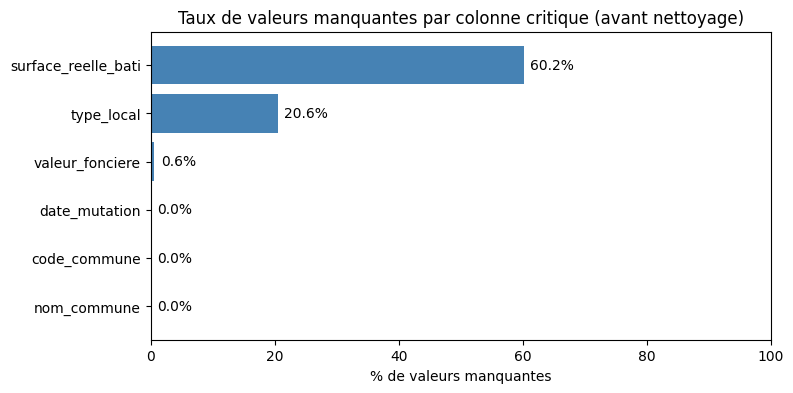


 Si on  supprimes les lignes avec des NaN dans ces colonnes : 250212 lignes seraient supprimées (60.4% du total).
Fort impact → envisage un autre traitement (ex: analyse séparée).


In [12]:
import matplotlib.pyplot as plt

def visualize_missing_impact(df):
    print("\n Analyse avant suppression des valeurs manquantes (colonnes critiques)")

    critical = ["date_mutation","valeur_fonciere","surface_reelle_bati","type_local","code_commune","nom_commune"]
    critical_presentes = [c for c in critical if c in df.columns]

    # Calcul du % de valeurs manquantes
    missing_stats = df[critical_presentes].isna().mean().sort_values(ascending=False) * 100

    # Estimation du nombre total de lignes qui seraient supprimées
    lignes_supprimees = len(df) - len(df.dropna(subset=critical_presentes))
    pct_supprimees = (lignes_supprimees / len(df)) * 100

    plt.figure(figsize=(8,4))
    bars = plt.barh(missing_stats.index, missing_stats.values, color="steelblue")
    plt.xlabel("% de valeurs manquantes")
    plt.title("Taux de valeurs manquantes par colonne critique (avant nettoyage)")
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()

    # Ajouter les pourcentages sur les barres
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.1f}%", va='center')

    plt.show()

    
    print(f"\n Si on  supprimes les lignes avec des NaN dans ces colonnes : "
          f"{lignes_supprimees} lignes seraient supprimées ({pct_supprimees:.1f}% du total).")

   
    if pct_supprimees < 10:
        print("Très faible impact → suppression recommandée.")
    elif pct_supprimees < 30:
        print("Impact modéré → suppression acceptable selon ton besoin.")
    else:
        print("Fort impact → envisage un autre traitement (ex: analyse séparée).")

# Exécution sur ton dataset typé
visualize_missing_impact(dvf_typed)


Interprétation de graphe  :
surface_reelle_bati a un taux élevé (60.2%) donc y a un risque de forte perte de données si on supprime les NaN.
type_local avec un taux modéré (20.6%)
valeur_fonciere: taux faible (0.6%) on peut supprimée les NAN
Les autres aucune donnée manquante.


=== Tableau des valeurs manquantes par type de bien ===


total_lignes  bati_na  terrain_na  \
type_local                                                                    
Appartement                                     109277        8       88200   
Dépendance                                      163725   163725      123652   
Local industriel. commercial ou assimilé         16518      515       10547   
Maison                                           39415        0        3413   

                                          %_bati_na  %_terrain_na  
type_local                                                         
Appartement                                    0.01         80.71  
Dépendance                                   100.00         75.52  
Local industriel. commercial ou assimilé       3.12         63.85  
Maison                                         0.00          8.66

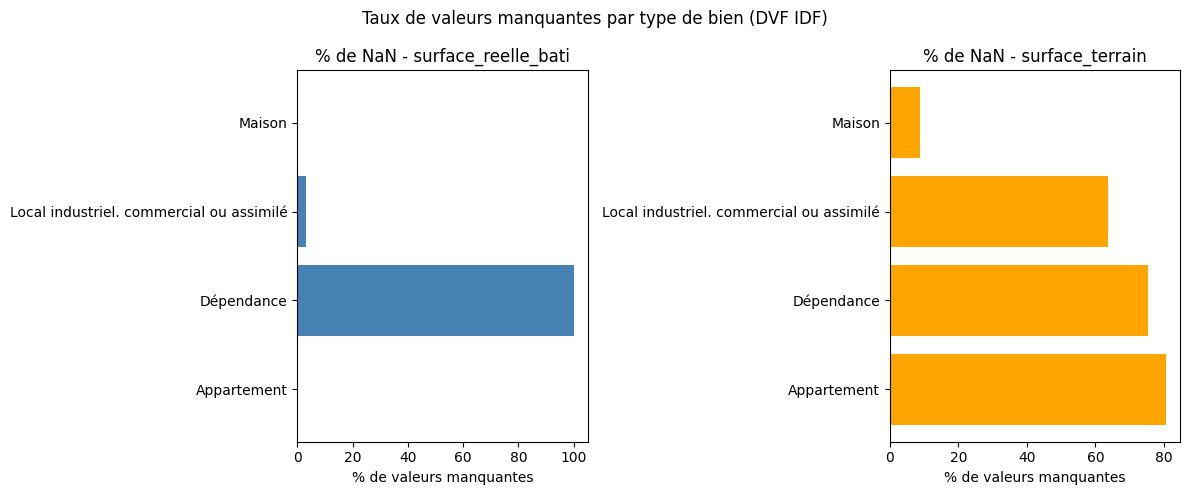

In [13]:
# On sélectionne les colonnes utiles
cols_check = ["type_local", "surface_reelle_bati", "surface_terrain"]
df_check = df_idf[cols_check].copy()

# Calcul du nombre et du % de valeurs manquantes par type_local
missing_summary = (
    df_check
    .groupby("type_local")
    .agg(
        total_lignes=("surface_reelle_bati", "size"),
        bati_na=("surface_reelle_bati", lambda x: x.isna().sum()),
        terrain_na=("surface_terrain", lambda x: x.isna().sum())
    )
)

# Pourcentage de NaN
missing_summary["%_bati_na"] = (missing_summary["bati_na"] / missing_summary["total_lignes"] * 100).round(2)
missing_summary["%_terrain_na"] = (missing_summary["terrain_na"] / missing_summary["total_lignes"] * 100).round(2)

print("=== Tableau des valeurs manquantes par type de bien ===")
display(missing_summary)

# --- Visualisation graphique ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1 : surface_reelle_bati
ax[0].barh(missing_summary.index, missing_summary["%_bati_na"], color="steelblue")
ax[0].set_title("% de NaN - surface_reelle_bati")
ax[0].set_xlabel("% de valeurs manquantes")

# Plot 2 : surface_terrain
ax[1].barh(missing_summary.index, missing_summary["%_terrain_na"], color="orange")
ax[1].set_title("% de NaN - surface_terrain")
ax[1].set_xlabel("% de valeurs manquantes")

plt.suptitle("Taux de valeurs manquantes par type de bien (DVF IDF)")
plt.tight_layout()
plt.show()


**Justification des seuils :**
on garde que les maison et les appartemant puisque notre persona ne s'interesse pas a acheter des terrain des locaux commerciaux ou des dependance qui sont des garage parking ..( non habitables )

### Filtrage par type de bien

In [14]:
def filter_logements(df):
    """
    Garde uniquement les logements (Appartement, Maison).
    Nettoie légèrement la colonne type_local (trim, casse).
    Affiche un bilan avant/après.
    """
    print("\n Filtrage sur les types de biens 'Appartement' et 'Maison'")

    # Photo avant
    vc_avant = df["type_local"].astype("string").str.strip().value_counts(dropna=False)
    print("\nRépartition AVANT filtrage (top 10) :")
    print(vc_avant.head(10))

    # Normalisation légère
    t = df["type_local"].astype("string").str.strip()
    t = t.str.replace(r"\s+", " ", regex=True)  
    t = t.str.title()  # Ex: 'appartement' -> 'Appartement'
    df = df.assign(type_local=t)

    # Filtre logements
    allowed = {"Appartement", "Maison"}
    mask = df["type_local"].isin(allowed)

    avant = len(df)
    df_logt = df.loc[mask].copy()
    suppr = avant - len(df_logt)

    print(f"\n Lignes conservées : {len(df_logt)} / {avant}  "
          f"(lignes écartées : {suppr})")
    print("Types conservés :", sorted(allowed))

    # Photo après
    vc_apres = df_logt["type_local"].value_counts(dropna=False)
    print("\nRépartition APRÈS filtrage :")
    print(vc_apres)

    autres = vc_avant[~vc_avant.index.isin(allowed)]
    if len(autres):
        print("\nTypes écartés (avec leurs volumes) :")
        print(autres)

    return df_logt

# applique sur ton DataFrame courant (ex: dvf_typed ou dvf_no_missing selon ton ordre)
dvf_logements = filter_logements(dvf_typed)



 Filtrage sur les types de biens 'Appartement' et 'Maison'

Répartition AVANT filtrage (top 10) :
type_local
Dépendance                                  163725
Appartement                                 109277
<NA>                                         85209
Maison                                       39415
Local industriel. commercial ou assimilé     16518
Name: count, dtype: Int64

 Lignes conservées : 148692 / 414144  (lignes écartées : 265452)
Types conservés : ['Appartement', 'Maison']

Répartition APRÈS filtrage :
type_local
Appartement    109277
Maison          39415
Name: count, dtype: Int64

Types écartés (avec leurs volumes) :
type_local
Dépendance                                  163725
<NA>                                         85209
Local industriel. commercial ou assimilé     16518
Name: count, dtype: Int64


In [15]:
# Diagnostic d’impact avant suppression (sur logements)

def preview_missing_impact_logements(df):
    critical = ["date_mutation","valeur_fonciere","surface_reelle_bati","type_local","code_commune","nom_commune"]
    critical = [c for c in critical if c in df.columns]
    miss_pct = (df[critical].isna().mean()*100).sort_values(ascending=False)

    to_drop = len(df) - len(df.dropna(subset=critical))
    pct_drop = 100 * to_drop / len(df)

    print(f"\nSi on supprime les NaN sur {critical} : {to_drop} lignes supprimées "
          f"({pct_drop:.1f}% de {len(df)}).")
    return miss_pct, to_drop, pct_drop

# Lance le diagnostic sur dvf_logements
_ = preview_missing_impact_logements(dvf_logements)



Si on supprime les NaN sur ['date_mutation', 'valeur_fonciere', 'surface_reelle_bati', 'type_local', 'code_commune', 'nom_commune'] : 622 lignes supprimées (0.4% de 148692).


In [16]:
# 1) Supprime uniquement les manquants critiques
def remove_missing_values_dvf(df):
    print("\nNettoyage des valeurs manquantes (critique, logements)…")
    avant = len(df)
    critical = ["date_mutation","valeur_fonciere","surface_reelle_bati","type_local","code_commune","nom_commune"]
    critical = [c for c in critical if c in df.columns]
    df = df.dropna(subset=critical)
    print(f"→ {avant - len(df)} lignes supprimées (NaN dans {critical})")
    print("Reste :", df.shape)
    return df

dvf_no_missing = remove_missing_values_dvf(dvf_logements)



Nettoyage des valeurs manquantes (critique, logements)…
→ 622 lignes supprimées (NaN dans ['date_mutation', 'valeur_fonciere', 'surface_reelle_bati', 'type_local', 'code_commune', 'nom_commune'])
Reste : (148070, 16)


### Suppression des doublons

In [17]:
# CODEZ ICI: Vérifier et supprimer les doublons potentiels

def diagnostic_doublons(df):
    print("\n Diagnostic des doublons dans la DVF logements")

    total = len(df)
    
    # 1️ Doublons exacts sur toutes les colonnes
    doublons_total = df.duplicated().sum()
    print(f"→ {doublons_total} doublons exacts sur {total} lignes ({doublons_total/total:.2%})")

    # 2️ Doublons selon les identifiants logiques (id_mutation + numero_disposition)
    if all(c in df.columns for c in ["id_mutation", "numero_disposition"]):
       
        doublons_mut_disp = df.duplicated(subset=["id_mutation","numero_disposition"]).sum()
        print(f"→ {doublons_mut_disp} doublons sur le couple (id_mutation, numero_disposition)")
    else:
        print(" Colonnes id_mutation / numero_disposition manquantes")

    # 3️ Diagnostic mutations avec plusieurs dispositions
    if "id_mutation" in df.columns:
        multi_mut = (df.groupby("id_mutation")["numero_disposition"]
                       .nunique().rename("nb_logements"))
        nb_multi = (multi_mut > 1).sum()
        print(f"→ {nb_multi} mutations contiennent plusieurs logements distincts ({nb_multi/len(multi_mut):.2%})")

        # Aperçu des cas multi-logements
        print("\nExemples de mutations avec plusieurs logements :")
        display(df[df["id_mutation"].isin(multi_mut[multi_mut > 1].index)].head(10))
    else:
        print(" Colonne id_mutation absente, impossible de vérifier les mutations multiples")

# Exécution du diagnostic
diagnostic_doublons(dvf_no_missing)



 Diagnostic des doublons dans la DVF logements
→ 15766 doublons exacts sur 148070 lignes (10.65%)
→ 31203 doublons sur le couple (id_mutation, numero_disposition)
→ 94 mutations contiennent plusieurs logements distincts (0.08%)

Exemples de mutations avec plusieurs logements :


id_mutation  numero_disposition date_mutation nature_mutation  \
2644944  2024-921531                   1    2024-08-02           Vente   
2644945  2024-921531                   2    2024-08-02           Vente   
2649250  2024-922988                   1    2024-08-01           Vente   
2649252  2024-922988                   2    2024-08-01           Vente   
2652454  2024-924139                   1    2024-11-15         Echange   
2652455  2024-924139                   2    2024-11-15         Echange   
2654451  2024-924545                   1    2024-11-27         Echange   
2654452  2024-924545                   2    2024-11-27         Echange   
2661049  2024-926924                   1    2024-02-29           Vente   
2661051  2024-926924                   2    2024-02-29           Vente   

         valeur_fonciere   type_local  nombre_pieces_principales  \
2644944         240000.0  Appartement                          3   
2644945         240000.0  Appartement                          3   
2649250         147000.0       Maison                          3   
2649252         147000.0       Maison                          3   
2652454           1000.0  Appartement                          3   
2652455           1000.0  Appartement                          4   
2654451            100.0       Maison                          4   
2654452            100.0       Maison                          4   
2661049          44500.0  Appartement                          2   
2661051          44500.0  Appartement                          2   

         surface_reelle_bati  surface_terrain code_departement code_commune  \
2644944                 58.0              NaN               77        77350   
2644945                 58.0              NaN               77        77350   
2649250                 60.0            529.0               77        77261   
2649252                 60.0            529.0               77        77261   
2652454                 76.0              NaN               77        77067   
2652455                 74.0              NaN               77        77067   
2654451                 57.0              6.0               77        77465   
2654452                 68.0             33.0               77        77465   
2661049                 44.0              NaN               77        77208   
2661051                 48.0              NaN               77        77208   

                     nom_commune code_postal  longitude   latitude  \
2644944        Ozoir-la-Ferrière     77330.0   2.676476  48.759950   
2644945        Ozoir-la-Ferrière     77330.0   2.676476  48.759950   
2649250  Lorrez-le-Bocage-Préaux     77710.0   2.876324  48.220862   
2649252  Lorrez-le-Bocage-Préaux     77710.0   2.876324  48.220862   
2652454                   Cesson     77240.0   2.607706  48.562858   
2652455                   Cesson     77240.0   2.607706  48.562858   
2654451          Thoury-Férottes     77940.0   2.939145  48.300835   
2654452          Thoury-Férottes     77940.0   2.939425  48.300641   
2661049                   Gouaix     77114.0   3.292562  48.476660   
2661051                   Gouaix     77114.0   3.292562  48.476660   

            id_parcelle  
2644944  77350000BE0234  
2644945  77350000BE0234  
2649250  772613750A0926  
2649252  772613750A0926  
2652454  77067000BD0310  
2652455  77067000BD0310  
2654451  77465000AH0267  
2654452  77465000AH0265  
2661049  77208000ZI0320  
2661051  77208000ZI0320

In [18]:
def clean_duplicates_dvf(df):
    print("\n Suppression des doublons")

    avant = len(df)

    # Étape 1 : doublons exacts
    df = df.drop_duplicates()
    apres_exact = len(df)
    print(f"→ {avant - apres_exact} doublons exacts supprimés")

    # Étape 2 : doublons mutation + disposition
    avant2 = len(df)
    df = df.drop_duplicates(subset=["id_mutation", "numero_disposition"])
    apres2 = len(df)
    print(f"→ {avant2 - apres2} doublons mutation/disposition supprimés")

    print(f" Total supprimé : {avant - apres2} lignes ({100*(avant - apres2)/avant:.2f}%)")
    print(f"Reste : {len(df)} lignes")
    return df

dvf_no_dups = clean_duplicates_dvf(dvf_no_missing)



 Suppression des doublons
→ 15766 doublons exacts supprimés
→ 15437 doublons mutation/disposition supprimés
 Total supprimé : 31203 lignes (21.07%)
Reste : 116867 lignes


### Filtrage des données aberrantes

On regardde si on pourra filtrer sur juste nature mutation == vente

In [19]:
# Répartition globale 
nat_counts = dvf_no_dups["nature_mutation"].value_counts()
nat_share  = (nat_counts / nat_counts.sum() * 100).round(2)
display(pd.DataFrame({"count": nat_counts, "share_%": nat_share}))

# Impact estimé si on garde seulement "Vente"
n_total = len(dvf_no_dups)
n_vente = (dvf_no_dups["nature_mutation"] == "Vente").sum()
print(f"Garder seulement 'Vente' = {n_vente} / {n_total} lignes ({100*n_vente/n_total:.1f}%)")

display(pd.crosstab(dvf_no_dups["nature_mutation"], dvf_no_dups["type_local"]))


count  share_%
nature_mutation                                    
Vente                               114099    97.63
Vente en l'état futur d'achèvement    2011     1.72
Adjudication                           363     0.31
Echange                                353     0.30
Vente terrain à bâtir                   22     0.02
Expropriation                           19     0.02

Garder seulement 'Vente' = 114099 / 116867 lignes (97.6%)


type_local                          Appartement  Maison
nature_mutation                                        
Adjudication                                260     103
Echange                                     317      36
Expropriation                                12       7
Vente                                     80658   33441
Vente en l'état futur d'achèvement         1970      41
Vente terrain à bâtir                         8      14

### Valeurs extremes


In [20]:
vf = pd.to_numeric(dvf_no_dups["valeur_fonciere"], errors="coerce")

print("Zéros ou négatifs :", (vf <= 0).sum())
print("Min / Max bruts :", vf.min(), "/", vf.max())

q = vf.quantile([0.001, 0.01, 0.05, 0.5, 0.95, 0.99, 0.999])
display(q.to_frame("valeur_fonciere"))


Zéros ou négatifs : 0
Min / Max bruts : 0.15 / 255000000.0


valeur_fonciere
0.001     1.000000e+02
0.010     1.900000e+04
0.050     9.500000e+04
0.500     2.796000e+05
0.950     1.031763e+06
0.990     2.400000e+06
0.999     1.327437e+07

In [21]:
cols = ["valeur_fonciere", "nombre_pieces_principales", "surface_reelle_bati", "surface_terrain"]
dvf_no_dups[cols].describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]).T

count           mean             std   min  \
valeur_fonciere            116867.0  426926.836221  1436313.331579  0.15   
nombre_pieces_principales  116867.0       3.119153        1.533045   0.0   
surface_reelle_bati        116867.0      68.742554       40.486827   1.0   
surface_terrain             31973.0     514.109311     1955.243892   1.0   

                            0.1%       1%       5%       25%       50%  \
valeur_fonciere            100.0  19000.0  95000.0  180000.0  279600.0   
nombre_pieces_principales    1.0      1.0      1.0       2.0       3.0   
surface_reelle_bati          7.0     12.0     20.0      40.0      63.0   
surface_terrain             13.0     40.0     93.0     238.0     389.0   

                                 75%         95%        99%            99.9%  \
valeur_fonciere            431428.92  1031762.85  2400000.0  13274369.380003   
nombre_pieces_principales        4.0         6.0        7.0             10.0   
surface_reelle_bati             87.0       141.0      202.0          321.268   
surface_terrain                529.0       991.0    2583.92        14658.484   

                                   max  
valeur_fonciere            255000000.0  
nombre_pieces_principales         55.0  
surface_reelle_bati             1500.0  
surface_terrain               167913.0

Commentaires : 
on remarque des valuers tres minimalistes non logique pour la variables "valeur_fonciere" tels:
-  des biens acheter à quelques centimes !!
- ou même prix ultra élévé comme le max qui est de 255000000 euro !!!

In [22]:
import plotly.express as px

for c in ["valeur_fonciere", "surface_reelle_bati", "surface_terrain"]:
    fig = px.box(dvf_no_dups, y=c, points="outliers")
    fig.update_layout(title=f"Boxplot — {c}", yaxis_type="log")
    fig.show()


A paritir des observations faite en haut j'ai décider de partir sur prix **max de 5M** et un prix **min de 7k** 
et pour les nombres de chambre un min de **1 seule chambre** et un max de**10 chambres**
et pou surface bati un **min de 5** et un **max de 500**

J'ai choisi ses données de sorte a ne pas perdre bcp de donnée et surtout de façon logique comparant a notre present 

In [23]:
# --- PARAMÈTRES MÀJ ---

MIN_PRICE      = 7_000
MAX_PRICE      = 5_000_000
MIN_ROOMS      = 1
MAX_ROOMS      = 10
MIN_SURF_BATI  = 5
MAX_SURF_BATI  = 500
#MIN_SURF_TERR  = 1
#MAX_SURF_TERR  = 100_000

df_f = dvf_no_dups.copy()

# ---- FILTRE SUR PRIX ----
df_f = df_f[
    (df_f["valeur_fonciere"] >= MIN_PRICE) &
    (df_f["valeur_fonciere"] <= MAX_PRICE)
]

# ---- FILTRE SUR NOMBRE DE PIÈCES ----
df_f = df_f[
    (df_f["nombre_pieces_principales"] >= MIN_ROOMS) &
    (df_f["nombre_pieces_principales"] <= MAX_ROOMS)
]

# ---- FILTRE SUR SURFACE BÂTIE ----
df_f = df_f[
    (df_f["surface_reelle_bati"] >= MIN_SURF_BATI) &
    (df_f["surface_reelle_bati"] <= MAX_SURF_BATI)
]



df_clean = df_f.copy()
df_clean.shape


(115520, 16)

In [24]:
init_n = dvf_no_dups.shape[0]
final_n = df_clean.shape[0]

print("Taille avant filtrage :", init_n)
print("Taille après filtrage :", final_n)
print("→ Lignes supprimées :", init_n - final_n)
print("→ % supprimées      :", round((init_n - final_n) / init_n * 100, 2), "%")


Taille avant filtrage : 116867
Taille après filtrage : 115520
→ Lignes supprimées : 1347
→ % supprimées      : 1.15 %


In [25]:
cols = ["valeur_fonciere", 
        "nombre_pieces_principales", 
        "surface_reelle_bati", 
        "surface_terrain"]

df_clean[cols].describe().T


count           mean            std     min  \
valeur_fonciere            115520.0  381544.928324  385254.091229  7000.0   
nombre_pieces_principales  115520.0       3.117945       1.492909     1.0   
surface_reelle_bati        115520.0      68.589153      39.220846     5.0   
surface_terrain             31608.0     476.694824    1276.062759     1.0   

                                  25%       50%       75%        max  
valeur_fonciere            182819.125  280000.0  430000.0  5000000.0  
nombre_pieces_principales         2.0       3.0       4.0       10.0  
surface_reelle_bati              41.0      63.0      87.0      473.0  
surface_terrain                 238.0     388.0     526.0   167913.0

---

## Transformation et enrichissement

### Création de variables dérivées

In [26]:
col = "surface_reelle_bati"

# conversion au cas où
df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

n_total = len(df_clean)

n_nan   = df_clean[col].isna().sum()
n_zero  = (df_clean[col] == 0).sum()
n_neg   = (df_clean[col] < 0).sum()

print("Diagnostic surface_reelle_bati ")
print(f"Total lignes : {n_total}")
print(f"→ NaN            : {n_nan}   ({n_nan/n_total*100:.2f} %)")
print(f"→ = 0             : {n_zero}   ({n_zero/n_total*100:.2f} %)")
print(f"→ < 0             : {n_neg}   ({n_neg/n_total*100:.4f} %)")

print("\nExemples NaN / 0 / <0 :")
display(df_clean[df_clean[col].isna() | (df_clean[col] <= 0)].head())


Diagnostic surface_reelle_bati 
Total lignes : 115520
→ NaN            : 0   (0.00 %)
→ = 0             : 0   (0.00 %)
→ < 0             : 0   (0.0000 %)

Exemples NaN / 0 / <0 :


Empty DataFrame
Columns: [id_mutation, numero_disposition, date_mutation, nature_mutation, valeur_fonciere, type_local, nombre_pieces_principales, surface_reelle_bati, surface_terrain, code_departement, code_commune, nom_commune, code_postal, longitude, latitude, id_parcelle]
Index: []

Le champ surface_reele_bati est striqutement postive donc il est bien nettoyé , et donc on peut bien l'utilisé pour calculer la nouvelle variable prix/m2

In [27]:
df_clean[col].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_frame()

surface_reelle_bati
count        115520.000000
mean             68.589153
std              39.220846
min               5.000000
1%               12.000000
5%               20.000000
25%              41.000000
50%              63.000000
75%              87.000000
95%             140.000000
99%             200.000000
max             473.000000

Calcul de la nouvelle colonne prix/m2

In [28]:
df_m2 = df_clean.copy()

# sécurité: s'assurer que c’est numérique
df_m2["valeur_fonciere"] = pd.to_numeric(df_m2["valeur_fonciere"], errors="coerce")
df_m2["surface_reelle_bati"] = pd.to_numeric(df_m2["surface_reelle_bati"], errors="coerce")

# calcul
df_m2["prix_m2"] = df_m2["valeur_fonciere"] / df_m2["surface_reelle_bati"]

print("Taille après calcul prix_m2 :", len(df_m2))
display(df_m2[["valeur_fonciere","surface_reelle_bati","prix_m2"]].head())


Taille après calcul prix_m2 : 115520


valeur_fonciere  surface_reelle_bati      prix_m2
2631654          98000.0                 66.0  1484.848485
2631658         163574.0                 57.0  2869.719298
2631660         136200.0                 30.0  4540.000000
2631664         305000.0                 87.0  3505.747126
2631665          72000.0                 11.0  6545.454545

In [29]:
# Global
display(df_m2["prix_m2"].describe(percentiles=[.01,.05,.5,.95,.99]).round(2))

# Par type de bien
display(
    df_m2.groupby("type_local")["prix_m2"]
         .describe(percentiles=[.01,.05,.5,.95,.99]).round(2)
)


count    115520.00
mean       6226.78
std        7134.53
min          24.40
1%          963.09
5%         1894.73
50%        4709.42
95%       13000.00
99%       24500.00
max      466666.67
Name: prix_m2, dtype: float64

count     mean      std   min       1%       5%      50%  \
type_local                                                                
Appartement  82054.0  7007.98  7978.10  24.4  1073.51  2029.41  5727.27   
Maison       33466.0  4311.37  3805.18  62.5   833.19  1618.82  3561.22   

                  95%       99%        max  
type_local                                  
Appartement  13889.56  27173.50  466666.67  
Maison        9000.00  15785.35  158333.33

In [30]:
import plotly.express as px

# Histogramme du prix/m²
fig = px.histogram(df_m2, x="prix_m2", nbins=80,
                   title="Distribution du prix/m² (€/m²)",
                   labels={"prix_m2":"€/m²"})
fig.update_layout(template="plotly_white")
fig.show()



D'apres l'histogramme on constate que ya qlq valeurs extreme pour prix/m2 malgré que la plus part sont entre 0 et 30k

In [31]:
### meth pour netpyer colonne prix/m2

# Winsorisation p1–p99 par code_commune × type_local
def winsorize_grp(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

df_m2_win = df_m2.copy()
df_m2_win["prix_m2"] = (
    df_m2.groupby(["code_commune","type_local"])["prix_m2"]
         .transform(lambda s: winsorize_grp(s, 0.01))
)

# Contrôle
before = df_m2["prix_m2"].describe(percentiles=[.01,.5,.99]).round(0)
after  = df_m2_win["prix_m2"].describe(percentiles=[.01,.5,.99]).round(0)
print("Avant :\n", before, "\n\nAprès winsorisation :\n", after)


"""
La winsorisation du prix au m² a permis de corriger les valeurs extrêmes tout en conservant 
l’ensemble des observations. L’écart-type est passé de 7 135 €/m² à 4 474 €/m², 
indiquant une distribution plus stable, mieux adaptée à l’analyse statistique et cartographique.
"""

Avant :
 count    115520.0
mean       6227.0
std        7135.0
min          24.0
1%          963.0
50%        4709.0
99%       24500.0
max      466667.0
Name: prix_m2, dtype: float64 

Après winsorisation :
 count    115520.0
mean       6028.0
std        4474.0
min         116.0
1%         1128.0
50%        4707.0
99%       22147.0
max      117502.0
Name: prix_m2, dtype: float64


'\nLa winsorisation du prix au m² a permis de corriger les valeurs extrêmes tout en conservant \nl’ensemble des observations. L’écart-type est passé de 7 135 €/m² à 4 474 €/m², \nindiquant une distribution plus stable, mieux adaptée à l’analyse statistique et cartographique.\n'

In [32]:
df_m2_win.shape


(115520, 17)

---

## Analyses statistiques descriptives


### Analyses par dimensions

#### Par type de bien

In [34]:
# CODEZ ICI: Statistiques par type de bien

#### Par région/département

In [36]:
# CODEZ ICI: Statistiques géographiques

---

## Export des données nettoyées

### Sauvegarde du dataset final

In [ ]:
df_m2_win.to_csv("dvf_idf_clean.csv", index=False, encoding="utf-8")


### Recommandations pour l'analyse

<!-- COMPLÉTEZ ICI: Notez les points importants pour l'analyse suivante -->
<!-- - Variables les plus pertinentes identifiées -->
<!-- - Limitations des données -->
<!-- - Suggestions pour les widgets -->

---

**Notebook préparé par :**
- Ashley OHNONA
- Harisoa RANDRIANASOLO
- Fairouz YOUDARENE
- Jennifer ZAHORA

**Date :** <!-- COMPLÉTEZ ICI: Date -->

**Dataset final :** `donnees_nettoyees.csv`